In [ ]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scripts.utils import get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, get_treatment_info
from datetime import datetime   

import seaborn as sns
sns.set_theme(style='white')

#from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

from scipy.stats import zscore, spearmanr

import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()


color_dict = {
    'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }

regions = list(color_dict.keys())
region_colors = list(color_dict.values())

samples = get_sample_ids_reorder()

In [ ]:
annot_excel = pd.read_excel('./data/pathology_annotation_exclude_info/annotation_completeness_information.xlsx',index_col=0)

ready_samples = annot_excel[annot_excel['file ready'] == 'full'].index.tolist()

# Download and pathology annotation for samples that are ready
ready_pathology_info_df = pd.DataFrame()
for sample in ready_samples:
    df = pd.read_csv('./data/pathology_annotation_exclude_info/'+sample+'.csv')
    df['sample_id'] = sample
    ready_pathology_info_df = pd.concat([ready_pathology_info_df,df],axis=0)

ready_pathology_info_df.index = ready_pathology_info_df['sample_id'] + '_' + ready_pathology_info_df['Barcode']

# Drop Spots annotated as Lumen or as 'Exclude'
ready_pathology_info_df = ready_pathology_info_df[~(ready_pathology_info_df['Pathology'].isin(['Exclude','Lumen']))]

# Drop sporadic spots that are missin annotation
#ready_pathology_info_df = ready_pathology_info_df[~(ready_pathology_info_df['Pathology'].isna())]

pathology_colors_dict = {
"Gleason 5": "#FF0000",
 "Gleason 4 cribriform": "#FF3333",
 "Gleason 4": "#FF6666",
 "Gleason 3": "#FF9999",
 "PIN": "#FC9D58",
 "Atrophy": "#FAF2AA",
 "Benign": "#6666FF",
 "Stroma": "#DDDDDD",
 "Inflammation": "#90EE90"}

pathology_categories = list(pathology_colors_dict.keys())
# Set the annotation categories - Some new ones may come in with more sample annotations
ready_pathology_info_df['Pathology'] = ready_pathology_info_df['Pathology'].astype('category').cat.set_categories(pathology_categories)

# This is the NTNU data annotation
""" 
pathology_colors_dict = {
"ISUP5": "#FF0000",
 "ISUP4": "#FF3333",
 "ISUP3": "#FF6666",
 "ISUP2": "#FF9999",
 "ISUP1": "#FFCCCC",
 "ISUPX": "#FC9D58",
 "ISUPY": "#FFB078",
 "PNI": "#FAF2AA",
 "Non-cancer glands": "#6666FF",
 "Stroma": "#DDDDDD",
 "Lymphocyte-enriched stroma": "#D0F5D0",
 "Lymphocytes": "#90EE90"}
 """

In [78]:
for sample in ready_samples:

    fig, axes = plt.subplots(1,3,figsize=(9,3),dpi=600)

    slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')

    # Copy the pathology annotation information onto the slide
    slide.obs['Pathology'] = ready_pathology_info_df.loc[slide.obs_names.intersection(ready_pathology_info_df.index)]['Pathology'].cat.remove_unused_categories()

    for i,key in enumerate(['none','Pathology','predicted_region']): 

        if key == 'Pathology':
            # Set the palette to only those that are present in the sample
            pal = [pathology_colors_dict[k] for k in  slide.obs[key].cat.categories.tolist()]

        elif key == 'predicted_region':
            pal = [color_dict[k] for k in  slide.obs[key].cat.categories.tolist()]

        # Set the palette
        sns.set_palette(sns.color_palette(pal))

        if key == 'none':
            sc.pl.spatial(slide,
                        size=0, alpha_img=1.0, legend_loc=None, # Old 1.3 and 0.8
                        crop_coord=sample_crop_coord[sample],
                        ax=axes[i],show=False
                        )
            
        else:
            sc.pl.spatial(slide,color=key,
                        size=1.5, alpha_img=0.0, legend_loc=None, # Old 1.3 and 0.8
                        crop_coord=sample_crop_coord[sample],
                        ax=axes[i],show=False
                        )
            


        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)

        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].set_title('')

    plt.savefig('plots/spatial_plots/pathology_regions/'+sample+'_pathology_regions_side_by_side.pdf',transparent=True)
    plt.clf()
    #plt.show()

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

Gleason 5
Gleason 4 cribriform
Gleason 4
Gleason 3
PIN
Atrophy
Benign
Stroma
Inflammation


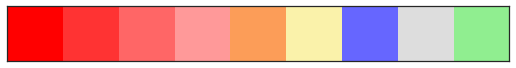

In [75]:
sns.palplot(sns.color_palette(pathology_colors_dict.values()))
plt.savefig('plots/spatial_plots/pathology_regions/pathology_color_palette.png',dpi=1200)
for k in pathology_categories:
    print(k)